In [47]:
blimp_tasks = ['anaphor_agreement', 'argument_structure', 'binding', 'control_raising', 'determiner_noun_agreement', 'ellipsis', 'filler_gap', 'irregular_forms', 'island_effects', 'npi_licensing', 'quantifiers', 'subject_verb_agreement']

In [48]:
checkpoints = [
    "0",
    "16384000",
    "32768000",
    # "49152000",
    "65536000",
    # "81920000",
    # "98304000",
    # "114688000",
    "131072000",
]

In [49]:
import json
from typing import Dict, List

def load_results_from_checkpoint(config, seed, run, checkpoints) -> Dict[str, List[float]]:
    
    results = {
        "config": [],
        "seed": [],
        "checkpoint": [],
        "blimp_task": [],
        "accuracy": []
    }
    
    for checkpoint in checkpoints:
        zeroshot_res_path = os.path.join(RESULTS_PATH, config, seed, run, checkpoint, "zeroshot")
        if os.path.exists(zeroshot_res_path):
            for task in blimp_tasks:
                task_res_path = os.path.join(zeroshot_res_path, task)
                with open(os.path.join(task_res_path, "eval_results.json"), "r") as f:
                    res = json.load(f)
                    results["config"].append(config)
                    results["seed"].append(seed)
                    results["checkpoint"].append(checkpoint)
                    results["blimp_task"].append(task)
                    results["accuracy"].append(res["eval_accuracy"])

    # final model
    zeroshot_res_path = os.path.join(RESULTS_PATH, config, seed, run, "zeroshot")
    if os.path.exists(zeroshot_res_path):
        for task in blimp_tasks:
            task_res_path = os.path.join(zeroshot_res_path, task)
            with open(os.path.join(task_res_path, "eval_results.json"), "r") as f:
                res = json.load(f)
                results["config"].append(config)
                results["seed"].append(seed)
                results["checkpoint"].append("10000000000")
                results["blimp_task"].append(task)
                results["accuracy"].append(res["eval_accuracy"])

    return results

In [50]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import OrderedDict

In [51]:
task2color={
    'anaphor_agreement': "indigo", 
    'argument_structure': "seagreen", 
    'binding': "teal", 
    'control_raising': "goldenrod", 
    'determiner_noun_agreement': "peru", 
    'ellipsis': "fuchsia", 
    'filler_gap': "crimson", 
    'irregular_forms': "grey", 
    'island_effects': "brown", 
    'npi_licensing': "wheat", 
    'quantifiers': "lightgreen", 
    'subject_verb_agreement': "darkcyan"
}

## OPT HF-default

In [52]:
RESULTS_PATH = "/local/models/babylm/bpe_50272/opt/10_epochs"
config = "hf_default"
seed = "0"
run = "run_2023-06-08-13-19-23"

In [53]:
checkpoints = [str(i) for i in range(11)]
results = load_results_from_checkpoint(config, seed, run, checkpoints)
df_opt = pd.DataFrame.from_dict(results)
print(df_opt)

         config seed checkpoint                 blimp_task  accuracy
0    hf_default    0          0          anaphor_agreement  0.354806
1    hf_default    0          0         argument_structure  0.574079
2    hf_default    0          0                    binding  0.552093
3    hf_default    0          0            control_raising  0.523420
4    hf_default    0          0  determiner_noun_agreement  0.504773
..          ...  ...        ...                        ...       ...
127  hf_default    0         10            irregular_forms  0.863613
128  hf_default    0         10             island_effects  0.609492
129  hf_default    0         10              npi_licensing  0.641360
130  hf_default    0         10                quantifiers  0.684183
131  hf_default    0         10     subject_verb_agreement  0.798013

[132 rows x 5 columns]


0.7487898619278743


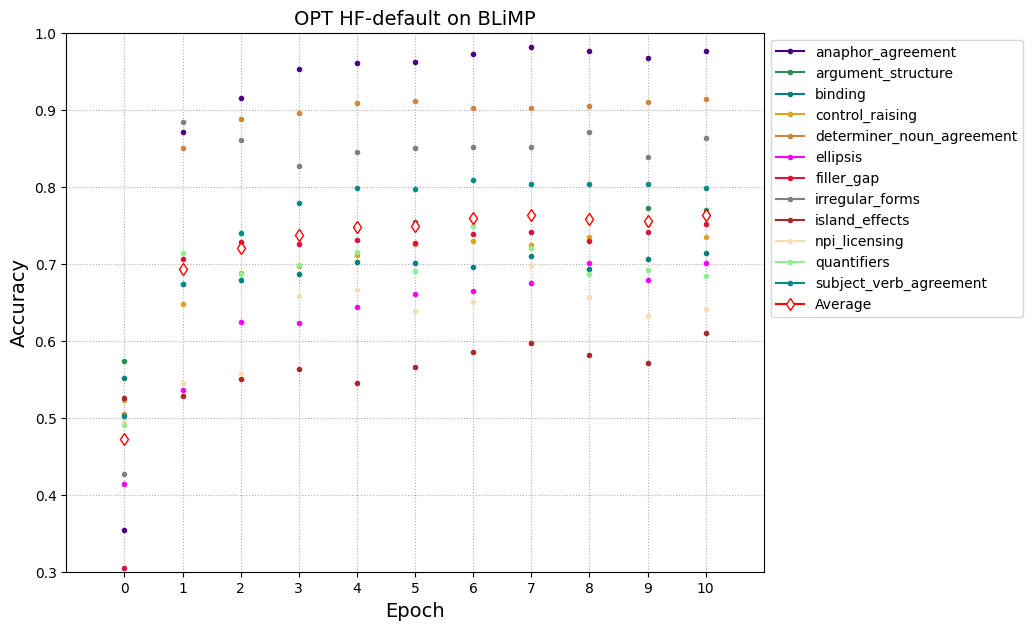

{'anaphor_agreement': 0.976, 'argument_structure': 0.7694, 'binding': 0.7136, 'control_raising': 0.7346, 'determiner_noun_agreement': 0.9139, 'ellipsis': 0.7003, 'filler_gap': 0.7518, 'irregular_forms': 0.8636, 'island_effects': 0.6095, 'npi_licensing': 0.6414, 'quantifiers': 0.6842, 'subject_verb_agreement': 0.798}


In [54]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)

baseline_acc_opt = {}

for i, checkpoint in enumerate(checkpoints):
    for task in blimp_tasks:
        df_c = df_opt[df_opt["checkpoint"]==checkpoint]
        df_ct = df_c[df_c["blimp_task"]==task]
        ax.plot(i, df_ct["accuracy"], linestyle="-", color=task2color[task], markersize=3, marker="o", label=task)

        if checkpoint == "10":
            # baseline
            baseline_acc_opt[task] = np.round(df_ct["accuracy"].item(),4)
    # overall
    df_c = df_opt[df_opt["checkpoint"]==checkpoint]
    acc_avg = np.mean(df_c["accuracy"])
    if checkpoint == "5":
        print(acc_avg)
    # print(config, task, num_params, round(acc_avg, 4), round(acc_se, 4))
    ax.plot(i, acc_avg, marker="d", label="Average", color="red", markerfacecolor="w")

    


xs = range(0,len(checkpoints))
ys = np.arange(0,1.01,0.1)

# configs4plotting = [config.split("_")[1] + "*" + config.split("_")[3] for config in configs]

labels = [str(i) for i in range(0,11)]
ax.set_xticks(xs, labels=labels, ha="center", rotation_mode="anchor", rotation=0)
ax.set_yticks(ys)
ax.grid(axis="both", linestyle=":")
ax.set_ylim([0.3,1])
ax.set_xlim([-1,11])
ax.set_title("OPT HF-default on BLiMP", fontsize=14)

plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.0, 1.0), fontsize=10, loc="upper left", ncol=1, fancybox=True, shadow=False)

plt.show()

print(baseline_acc_opt)

### Smaller OPT model (2x192, 8 heads) on identical vocabulary

In [26]:
RESULTS_PATH = "/local/models/babylm/bpe_50272/opt/heads_8"
config = "layers_2_hs_192_heads_8_cl_128"
seed = "0"
run = "run_2023-06-13-03-45-12"

In [27]:
checkpoints = [str(i) for i in [0,1,5,10]]
results = load_results_from_checkpoint(config, seed, run, checkpoints)
df_all= pd.DataFrame.from_dict(results)
print(df_all)

                            config seed checkpoint                 blimp_task  \
0   layers_2_hs_192_heads_8_cl_128    0          0          anaphor_agreement   
1   layers_2_hs_192_heads_8_cl_128    0          0         argument_structure   
2   layers_2_hs_192_heads_8_cl_128    0          0                    binding   
3   layers_2_hs_192_heads_8_cl_128    0          0            control_raising   
4   layers_2_hs_192_heads_8_cl_128    0          0  determiner_noun_agreement   
5   layers_2_hs_192_heads_8_cl_128    0          0                   ellipsis   
6   layers_2_hs_192_heads_8_cl_128    0          0                 filler_gap   
7   layers_2_hs_192_heads_8_cl_128    0          0            irregular_forms   
8   layers_2_hs_192_heads_8_cl_128    0          0             island_effects   
9   layers_2_hs_192_heads_8_cl_128    0          0              npi_licensing   
10  layers_2_hs_192_heads_8_cl_128    0          0                quantifiers   
11  layers_2_hs_192_heads_8_

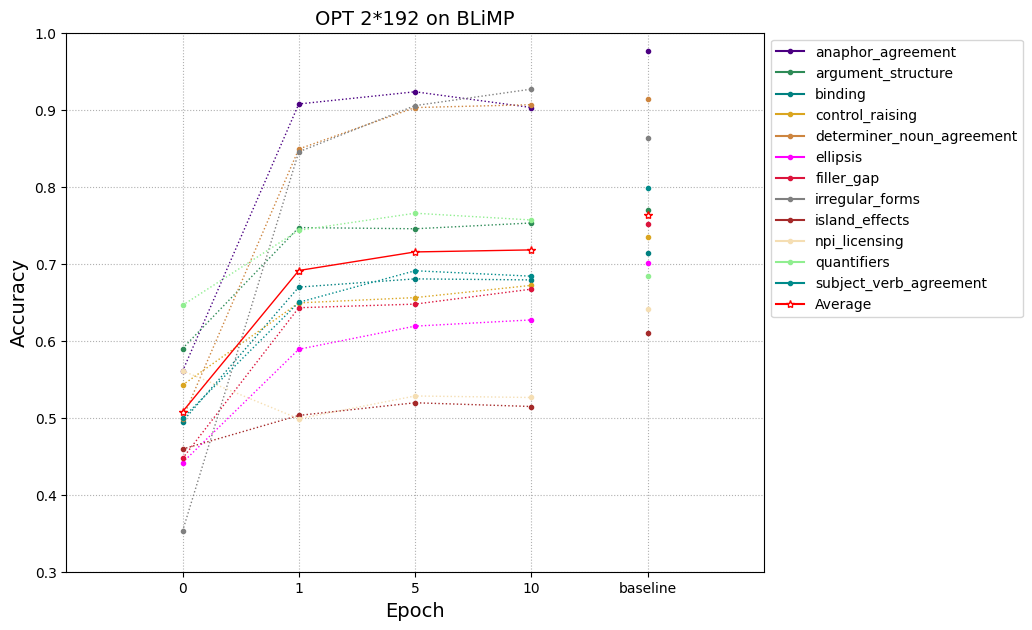

In [28]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)

# results per task
for task in df_all["blimp_task"].unique():
    accuracies_task = []
    for checkpoint in checkpoints:
        df = df_all[df_all["checkpoint"]==checkpoint]
        df = df[df["blimp_task"]==task]
        acc_avg = np.mean(df["accuracy"])
        accuracies_task.append(acc_avg)
    
    xs = range(len(accuracies_task))
    ax.plot(xs, accuracies_task, linestyle=":", linewidth=1, color=task2color[task], markersize=3, marker="o", label=task)


# overall
accuracies_avg = []

for checkpoint in checkpoints:
    df = df_all[df_all["checkpoint"]==checkpoint]
    accuracies_avg.append(np.mean(df["accuracy"]))

xs = range(len(accuracies_avg))
ax.plot(xs, accuracies_avg, marker="*", linewidth=1, label="Average", color="red", markerfacecolor="w")

# baseline
x = len(accuracies_avg)
for task, acc in baseline_acc_opt.items():
    ax.plot(x, acc, color=task2color[task], markersize=3, marker="o", label=task)
acc_avg = np.mean(list(baseline_acc_opt.values()))
ax.plot(x, acc_avg, marker="*", label="Average", color="red", markerfacecolor="w", markersize=6)

xs = range(0,len(checkpoints)+1)
ys = np.arange(0,1.01,0.1)

labels = [str(i) for i in checkpoints] + ["baseline"]
ax.set_xticks(xs, labels=labels, ha="center", rotation_mode="anchor", rotation=0)
ax.set_yticks(ys)
ax.grid(axis="both", linestyle=":")
ax.set_ylim([0.3,1])
ax.set_xlim([-1,5])
ax.set_title("OPT 2*192 on BLiMP", fontsize=14)

plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.0, 1.0), fontsize=10, loc="upper left", ncol=1, fancybox=True, shadow=False)

plt.show()

## Middling OPT model (8*768)

In [29]:
RESULTS_PATH = "/local/models/babylm/bpe_50272/opt/heads_8"
config = "layers_8_hs_768_heads_8_cl_128"
seed = "0"
run = "run_2023-06-10-11-06-01"

In [30]:
checkpoints = [str(i) for i in [0,1,5,10]]
results = load_results_from_checkpoint(config, seed, run, checkpoints)
df_all= pd.DataFrame.from_dict(results)
print(df_all)

                            config seed checkpoint                 blimp_task  \
0   layers_8_hs_768_heads_8_cl_128    0          0          anaphor_agreement   
1   layers_8_hs_768_heads_8_cl_128    0          0         argument_structure   
2   layers_8_hs_768_heads_8_cl_128    0          0                    binding   
3   layers_8_hs_768_heads_8_cl_128    0          0            control_raising   
4   layers_8_hs_768_heads_8_cl_128    0          0  determiner_noun_agreement   
5   layers_8_hs_768_heads_8_cl_128    0          0                   ellipsis   
6   layers_8_hs_768_heads_8_cl_128    0          0                 filler_gap   
7   layers_8_hs_768_heads_8_cl_128    0          0            irregular_forms   
8   layers_8_hs_768_heads_8_cl_128    0          0             island_effects   
9   layers_8_hs_768_heads_8_cl_128    0          0              npi_licensing   
10  layers_8_hs_768_heads_8_cl_128    0          0                quantifiers   
11  layers_8_hs_768_heads_8_

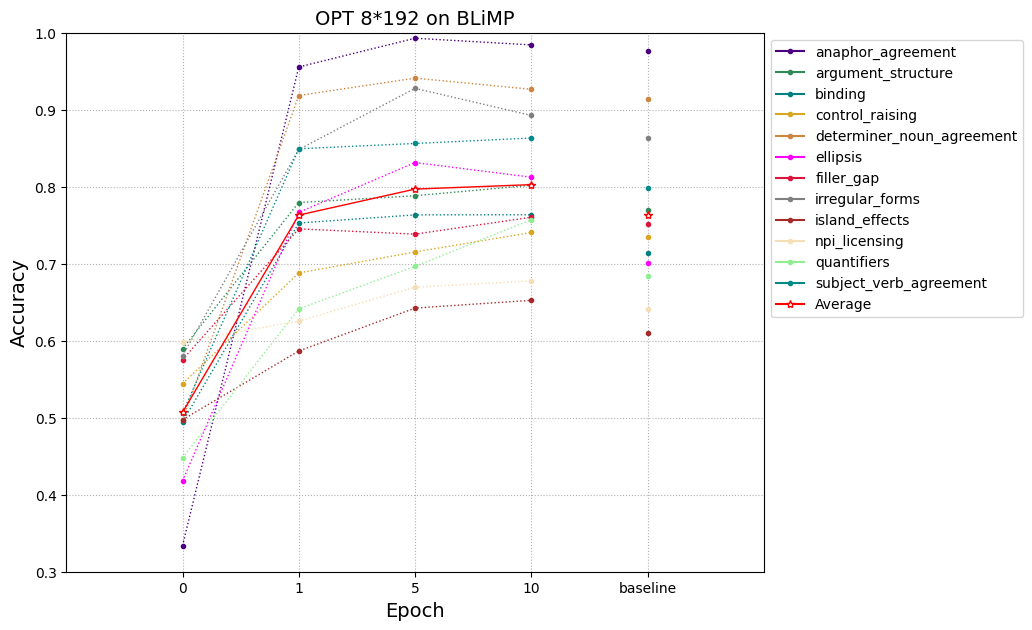

In [31]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)

# results per task
for task in df_all["blimp_task"].unique():
    accuracies_task = []
    for checkpoint in checkpoints:
        df = df_all[df_all["checkpoint"]==checkpoint]
        df = df[df["blimp_task"]==task]
        acc_avg = np.mean(df["accuracy"])
        accuracies_task.append(acc_avg)
    
    xs = range(len(accuracies_task))
    ax.plot(xs, accuracies_task, linestyle=":", linewidth=1, color=task2color[task], markersize=3, marker="o", label=task)


# overall
accuracies_avg = []
for checkpoint in checkpoints:
    df = df_all[df_all["checkpoint"]==checkpoint]
    accuracies_avg.append(np.mean(df["accuracy"]))

xs = range(len(accuracies_avg))
ax.plot(xs, accuracies_avg, marker="*", linewidth=1, label="Average", color="red", markerfacecolor="w")

# baseline
x = len(accuracies_avg)
for task, acc in baseline_acc_opt.items():
    ax.plot(x, acc, color=task2color[task], markersize=3, marker="o", label=task)
acc_avg = np.mean(list(baseline_acc_opt.values()))
ax.plot(x, acc_avg, marker="*", label="Average", color="red", markerfacecolor="w", markersize=6)

xs = range(0,len(checkpoints)+1)
ys = np.arange(0,1.01,0.1)

labels = [str(i) for i in checkpoints] + ["baseline"]
ax.set_xticks(xs, labels=labels, ha="center", rotation_mode="anchor", rotation=0)
ax.set_yticks(ys)
ax.grid(axis="both", linestyle=":")
ax.set_ylim([0.3,1])
ax.set_xlim([-1,5])
ax.set_title("OPT 8*192 on BLiMP", fontsize=14)

plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.0, 1.0), fontsize=10, loc="upper left", ncol=1, fancybox=True, shadow=False)

plt.show()

### Results for different model sizes

In [32]:
RESULTS_PATH = "/local/models/babylm/bpe_50272/opt/heads_8"

checkpoints = ["0","1","5","10"]

In [33]:
config2size = {
    "1*96"
    "2*96": 568128,
	"4*96": 791808,
	"8*96": 1239168,
	"16*96": 2133888,
    "2*192": 1578624,
	"4*192": 2468352,
	"8*192": 4247808,
    "16*192": 7806720,
	"2*384": 4926720,
	"4*384": 8475648,
	"8*384": 15573504,
    "16*384": 29769216,
	"2*768": 15751680,
	"4*768": 29927424,
	"8*768": 58278912,
    "16*768": 114981888
}

In [34]:
from collections import defaultdict

dfs = []

for config in os.listdir(RESULTS_PATH):
    # if "96" in config:
    #     print(f"Skipping config {config}")
    #     continue
    config_path = os.path.join(RESULTS_PATH, config)
    for seed in os.listdir(config_path):
        seed_path = os.path.join(config_path, seed)
        run = os.listdir(seed_path)[0]
        results = load_results_from_checkpoint(config, seed, run, checkpoints)
        df = pd.DataFrame.from_dict(results)
        dfs.append(df)

df_all = pd.concat(dfs)

print(len(df_all))

df_all["hidden_size"] = df_all["config"].str.split("_").str[3].apply(pd.to_numeric)
df_all["layers"] = df_all["config"].str.split("_").str[1].apply(pd.to_numeric)
df_all["checkpoint"] = df_all["checkpoint"].apply(pd.to_numeric)
df_all["config_short"] = df_all["layers"].astype(str) + "*" + df_all["hidden_size"].astype(str)
df_all["num_params"] = [config2size[config_short] for config_short in df_all["config_short"]]
print(df_all["config_short"].unique())
print(df_all["num_params"].unique())
df_all = df_all[df_all["checkpoint"]<=5]
df_all = df_all.sort_values(by=["checkpoint", "num_params"], ascending=True)
# df_all = df_all.sort_values(by=["checkpoint", "hidden_size", "layers", ], ascending=True)

print(df_all)

996
['2*192' '8*192' '4*768' '4*192' '8*384' '2*384' '4*384' '8*768' '2*768'
 '16*192' '16*384' '16*96']
[ 1578624  4247808 29927424  2468352 15573504  4926720  8475648 58278912
 15751680  7806720 29769216  2133888]
                            config seed  checkpoint  \
0   layers_2_hs_192_heads_8_cl_128    0           0   
1   layers_2_hs_192_heads_8_cl_128    0           0   
2   layers_2_hs_192_heads_8_cl_128    0           0   
3   layers_2_hs_192_heads_8_cl_128    0           0   
4   layers_2_hs_192_heads_8_cl_128    0           0   
..                             ...  ...         ...   
31  layers_8_hs_768_heads_8_cl_128    0           5   
32  layers_8_hs_768_heads_8_cl_128    0           5   
33  layers_8_hs_768_heads_8_cl_128    0           5   
34  layers_8_hs_768_heads_8_cl_128    0           5   
35  layers_8_hs_768_heads_8_cl_128    0           5   

                   blimp_task  accuracy  hidden_size  layers config_short  \
0           anaphor_agreement  0.560327       

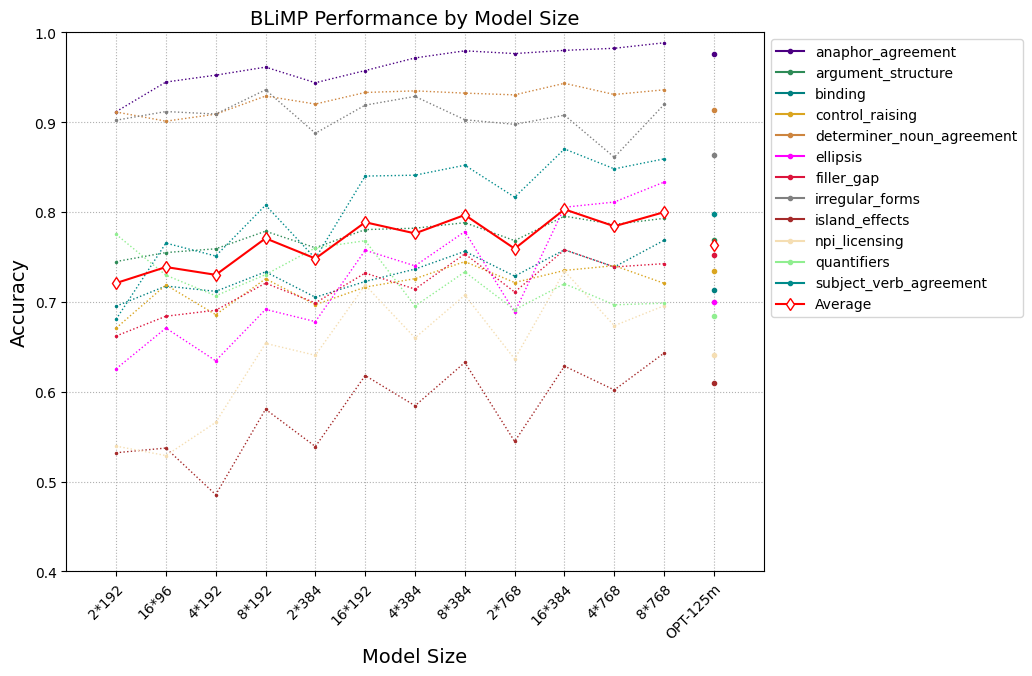

In [35]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)


# results per task
for task in df_all["blimp_task"].unique():
    
    accuracies_task = []
    
    for config in df_all["config"].unique():
        df = df_all[df_all["checkpoint"]==5]
        df = df[df["blimp_task"]==task]
        df = df[df["config"]==config]
        # print(i, config, task, np.mean(df["accuracy"]))
        acc_avg = np.mean(df["accuracy"])
        # ax.plot(i, acc_avg, linestyle="-", color=task2color[task], markersize=3, marker="o", label=task)
        accuracies_task.append(acc_avg)
    
    xs = range(len(accuracies_task))
    ax.plot(xs, accuracies_task, linestyle=":", linewidth=1.0, color=task2color[task], markersize=1.5, marker="o", label=task)

# average
accuracies_avg = []
for config in df_all["config"].unique():
    # overall
    df = df_all[df_all["checkpoint"]==5]
    df = df[df["config"]==config]
    accuracies_avg.append(np.mean(df["accuracy"]))

xs = range(len(accuracies_avg))
ax.plot(xs, accuracies_avg, marker="d", label="Average", color="red", markerfacecolor="w")

# baseline
x = len(accuracies_avg)
for task, acc in baseline_acc_opt.items():
    ax.plot(x, acc, color=task2color[task], markersize=3, marker="o", label=task)
acc_avg = np.mean(list(baseline_acc_opt.values()))
ax.plot(x, acc_avg, marker="d", label="Average", color="red", markerfacecolor="w", markersize=6)

xs = range(0,len(df_all["config"].unique())+1)
ys = np.arange(0,1.01,0.1)

configs4plotting = [config_short for config_short in df_all["config_short"].unique()] + ["OPT-125m"]

ax.set_xticks(xs, labels=configs4plotting, ha="right", rotation_mode="anchor", rotation=45)
ax.set_yticks(ys)
ax.grid(axis="both", linestyle=":")
ax.set_ylim([0.4,1])
ax.set_xlim([-1,13])
ax.set_title("BLiMP Performance by Model Size", fontsize=14)

plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Model Size", fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.0, 1.0), fontsize=10, loc="upper left", ncol=1, fancybox=True, shadow=False)

plt.show()

## Diff Heads

In [36]:
RESULTS_PATH = "/data/users/jsteuer/models/babylm/bpe_50272/opt/diff_heads/"

checkpoints = ["0","1","5"]

In [37]:
dfs = []

for config in os.listdir(RESULTS_PATH):
    print(config)
    config_path = os.path.join(RESULTS_PATH, config)
    for seed in os.listdir(config_path):
        seed_path = os.path.join(config_path, seed)
        run = os.listdir(seed_path)[0]
        results = load_results_from_checkpoint(config, seed, run, checkpoints)
        df = pd.DataFrame.from_dict(results)
        dfs.append(df)

df_all = pd.concat(dfs)

print(len(df_all))

layers_8_hs_384_heads_1_cl_128
layers_8_hs_384_heads_2_cl_128
layers_8_hs_384_heads_8_cl_128
layers_8_hs_384_heads_4_cl_128
layers_8_hs_384_heads_12_cl_128
180


In [38]:
df_all["heads"] = df_all["config"].str.split("_").str[5].apply(pd.to_numeric)
df_all["checkpoint"] = df_all["checkpoint"].apply(pd.to_numeric)
# df_all["config_short"] = df_all["layers"].astype(str) + "*" + df_all["hidden_size"].astype(str)
# df_all["num_params"] = [config2size[config_short] for config_short in df_all["config_short"]]
# print(df_all["config_short"].unique())
# print(df_all["num_params"].unique())
df_all = df_all[df_all["checkpoint"] == 5]
# df_all = df_all.sort_values(by=["checkpoint"], ascending=True)
# df_all = df_all.sort_values(by=["checkpoint", "hidden_size", "layers", ], ascending=True)

print(df_all["heads"].unique())

[ 1  2  8  4 12]


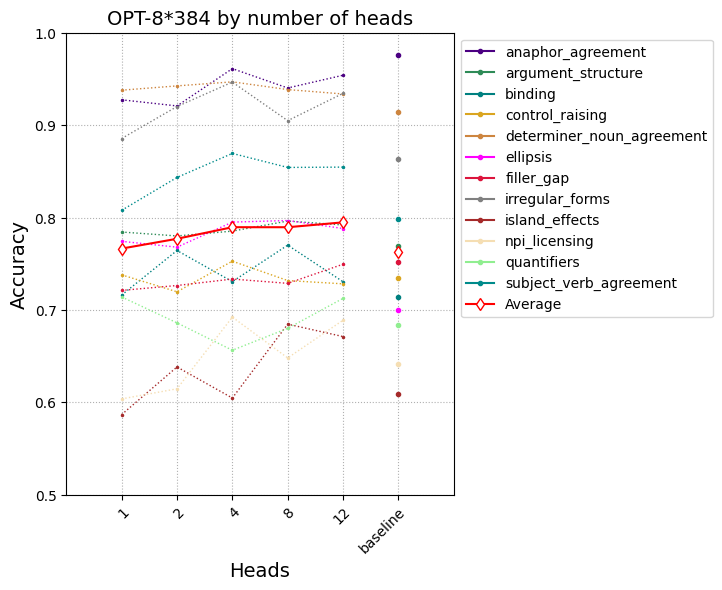

In [39]:
fig = plt.figure(figsize=(5,6))
ax = fig.add_subplot(111)


# results per task
for task in df_all["blimp_task"].unique():
    
    accuracies_task = []
    
    for config in df_all["config"].unique():
        df = df_all[df_all["checkpoint"]==5]
        df = df[df["blimp_task"]==task]
        df = df[df["config"]==config]
        # print(i, config, task, np.mean(df["accuracy"]))
        acc_avg = np.mean(df["accuracy"])
        # ax.plot(i, acc_avg, linestyle="-", color=task2color[task], markersize=3, marker="o", label=task)
        accuracies_task.append(acc_avg)
    
    xs = range(len(accuracies_task))
    ax.plot(xs, accuracies_task, linestyle=":", linewidth=1.0, color=task2color[task], markersize=1.5, marker="o", label=task)

# average
accuracies_avg = []
for config in df_all["config"].unique():
    # overall
    df = df_all[df_all["checkpoint"]==5]
    df = df[df["config"]==config]
    accuracies_avg.append(np.mean(df["accuracy"]))

xs = range(len(accuracies_avg))
ax.plot(xs, accuracies_avg, marker="d", label="Average", color="red", markerfacecolor="w")

# baseline
x = len(accuracies_avg)
for task, acc in baseline_acc_opt.items():
    ax.plot(x, acc, color=task2color[task], markersize=3, marker="o", label=task)
acc_avg = np.mean(list(baseline_acc_opt.values()))
ax.plot(x, acc_avg, marker="d", label="Average", color="red", markerfacecolor="w", markersize=6)

xs = range(0,len(df_all["heads"].unique())+1)
ys = np.arange(0,1.01,0.1)

# configs4plotting = [config_short for config_short in df_all["config_short"].unique()] + ["OPT-125m"]

ax.set_xticks(xs, labels=["1", "2", "4", "8", "12", "baseline"], ha="right", rotation_mode="anchor", rotation=45)
ax.set_yticks(ys)
ax.grid(axis="both", linestyle=":")
ax.set_ylim([0.5,1])
ax.set_xlim([-1,6])
ax.set_title("OPT-8*384 by number of heads", fontsize=14)

plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Heads", fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.0, 1.0), fontsize=10, loc="upper left", ncol=1, fancybox=True, shadow=False)

plt.show()

## Ordered vs non-ordered

In [40]:
RESULTS_PATH = "/data/users/jsteuer/models/babylm/opt/diff_train_set/"

In [41]:
dfs = []

for train_file in os.listdir(RESULTS_PATH):
    print(train_file)
    config = os.listdir(os.path.join(RESULTS_PATH, train_file))[0]
    config_path = os.path.join(RESULTS_PATH, train_file, config)
    for seed in ["0","13"]:
        seed_path = os.path.join(config_path, seed)
        run_dir = os.listdir(seed_path)[0]
        results = load_results_from_checkpoint(config_path, seed, run_dir, checkpoints)
        df = pd.DataFrame.from_dict(results)
        df = df[df["checkpoint"]=="5"]
        df["config"] = [train_file for _ in range(len(df))]
        dfs.append(df)

df_all = pd.concat(dfs)

print(len(df_all))

babylm_full.train
babylm_min20.train
babylm_min20_ordered.train
72


In [42]:
print(df_all["config"].unique())

['babylm_full.train' 'babylm_min20.train' 'babylm_min20_ordered.train']


In [43]:
# df_all["config_short"] = df_all["layers"].astype(str) + "*" + df_all["hidden_size"].astype(str)
# df_all["num_params"] = [config2size[config_short] for config_short in df_all["config_short"]]
# print(df_all["config_short"].unique())
# print(df_all["num_params"].unique())
# df_all = df_all.sort_values(by=["checkpoint"], ascending=True)
# df_all = df_all.sort_values(by=["checkpoint", "hidden_size", "layers", ], ascending=True)
print(df_all.head())

               config seed checkpoint                 blimp_task  accuracy
24  babylm_full.train    0          5          anaphor_agreement  0.972393
25  babylm_full.train    0          5         argument_structure  0.803225
26  babylm_full.train    0          5                    binding  0.762392
27  babylm_full.train    0          5            control_raising  0.734202
28  babylm_full.train    0          5  determiner_noun_agreement  0.948290


range(0, 3)
[0.7835458259506511, 0.7521782791332617, 0.7471558487031457]


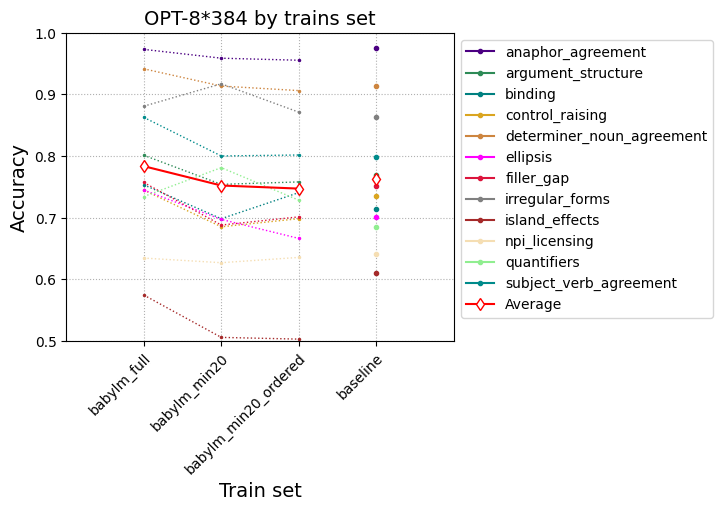

In [44]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)


# results per task
for task in df_all["blimp_task"].unique():
    
    accuracies_task = []
    
    for config in df_all["config"].unique():
        df = df_all[df_all["blimp_task"]==task]
        df = df[df["config"]==config]
        # print(i, config, task, np.mean(df["accuracy"]))
        acc_avg = np.mean(df["accuracy"])
        # ax.plot(i, acc_avg, linestyle="-", color=task2color[task], markersize=3, marker="o", label=task)
        accuracies_task.append(acc_avg)
    
    xs = range(len(accuracies_task))
    ax.plot(xs, accuracies_task, linestyle=":", linewidth=1.0, color=task2color[task], markersize=1.5, marker="o", label=task)

# average
accuracies_avg = []
for config in df_all["config"].unique():
    # overall
    df = df_all[df_all["config"]==config]
    accuracies_avg.append(np.mean(df["accuracy"]))

xs = range(len(accuracies_avg))
print(xs)
print(accuracies_avg)
ax.plot(xs, accuracies_avg, marker="d", label="Average", color="red", markerfacecolor="w")

# baseline
x = len(accuracies_avg)
for task, acc in baseline_acc_opt.items():
    ax.plot(x, acc, color=task2color[task], markersize=3, marker="o", label=task)
acc_avg = np.mean(list(baseline_acc_opt.values()))
ax.plot(x, acc_avg, marker="d", label="Average", color="red", markerfacecolor="w", markersize=6)

xs = range(0,len(df_all["config"].unique())+1)
ys = np.arange(0,1.01,0.1)

# configs4plotting = [config_short for config_short in df_all["config_short"].unique()] + ["OPT-125m"]

labels = [ts.split(".")[0] for ts in df_all["config"].unique()]

ax.set_xticks(xs, labels=labels + ["baseline"], ha="right", rotation_mode="anchor", rotation=45)
ax.set_yticks(ys)
ax.grid(axis="both", linestyle=":")
ax.set_ylim([0.5,1])
ax.set_xlim([-1,4])
ax.set_title("OPT-8*384 by trains set", fontsize=14)

plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Train set", fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.0, 1.0), fontsize=10, loc="upper left", ncol=1, fancybox=True, shadow=False)

plt.show()